In [1]:
#%reset
# import libraries
import sympy as sym
import numpy as np
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

#sym.init_printing()
from IPython.display import display, HTML

In [2]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
m = ConcreteModel() # create model using pyomo
N = 100 # number of nodes (much like samples used between a certain time period)
hm=0.9/N # Scaling factor for time-step
m.N = RangeSet(N) 
m.damping=20

mass_b=2 # Mass of the base
mass_l=1 # Mass of the links
len_b=0.3 # Length of the base
m.l_min=0.2 # Links min length
m.l_max=len_b # Links max length
m.F_max=160 # Maximum force that can be applied
m.t_max=12 # Maximum torque
m.w_max=44 # Max angular velocity (omega)
m.dl_max=3
m.distance=5

print('Yeet')

Yeet


In [3]:
# create symbolic variables
g = sym.symbols('g')
mb,ml = sym.symbols(['m_{body}','m_{leg}']) # mass
lb = sym.symbols(['l_{body}']) # length
ll = sym.symbols(['l_{leg}'])
Inb,Inl = sym.symbols(['I_{body}','I_{leg}']) # moment of intertia

x,z,thLl,thRl,rL,rR = sym.symbols(['x','z','\\theta_{Lleg}','\\theta_{Rleg}','r_{left}','r_{right}'])
dx,dz,dthLl,dthRl,drL,drR = sym.symbols(['\dot{x}','\dot{z}','\dot{\\theta}_{Lleg}','\dot{\\theta}_{Rleg}','\dot{r}_{left}','\dot{r}_{right}']) 
ddx,ddz,ddthLl,ddthRl,ddrL,ddrR = sym.symbols(['\ddot{x}','\ddot{z}','\ddot{\\theta}_{Lleg}','\ddot{\\theta}_{Rleg}','\ddot{r}_{left}','\ddot{r}_{right}'])

q = sym.Matrix([[x],[z],[thLl],[thRl],[rL],[rR]])
dq = sym.Matrix([[dx],[dz],[dthLl],[dthRl],[drL],[drR]])
ddq = sym.Matrix([[ddx],[ddz],[ddthLl],[ddthRl],[ddrL],[ddrR]])

# forces
FL,FR,tauL,tauR,GRFx,GRFz = sym.symbols(['F_{left}','F_{right}','\\tau_{left}','\\tau_{right}','G_x','G_z']) 
print('Yeet')

Yeet


## EoM generaion

In [4]:
# STEP 1: position vector (COM of each link), as well as other required positions. 
rb = sym.Matrix([[x],
                [z]])

rLl = sym.Matrix([[x + (0.5*rL)*sym.cos(thLl)],
                 [z - (0.5*rL)*sym.sin(thLl)]])
rRl = sym.Matrix([[x + (0.5*rR)*sym.cos(thRl)],
                 [z - (0.5*rR)*sym.sin(thRl)]])


footLx = sym.Matrix([x + rL*sym.cos(thLl)])
footLz = sym.Matrix([z - rL*sym.sin(thLl)]) 
footLz = footLz[0].simplify()
footL_pos= sym.Matrix([[footLx],[0],[footLz]])

footRx = sym.Matrix([x + rR*sym.cos(thRl)])
footRz = sym.Matrix([z - rR*sym.sin(thRl)]) 
footRz = footRz[0].simplify()
footR_pos= sym.Matrix([[footRx],[0],[footRz]])
print('Done')

Done


In [5]:
# STEP 2: generate expressions for the system space velocities from the jacobians
# the Jacobians
Jb = rb.jacobian(q)
JLl = rLl.jacobian(q)
JRl = rRl.jacobian(q)

vb = Jb*dq
vLl = JLl*dq
vRl = JRl*dq

footLdx = footLx.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
footLdx = footLdx[0].simplify()
footRdx = footRx.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
footRdx = footRdx[0].simplify()
print('Done')

Done


In [6]:
# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb]]) # Mass matrix of body
Ml = sym.Matrix([[ml,ml]]) # Mass matrix of leg(s)

Ib=sym.Matrix([[Inb]]) # Inertia matrix of body
Il=sym.Matrix([[Inl]]) # Inertia matrix of leg(s)

WLl=sym.Matrix([[dthLl]]) # Angular volocity of left-leg
WRl=sym.Matrix([[dthRl]]) # Angular volocity of right-leg

# linear kinetic energy:
T1 = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) + 0.5*Ml*sym.matrix_multiply_elementwise(vLl,vLl) + 0.5*Ml*sym.matrix_multiply_elementwise(vRl,vRl)
# angular kinetic energy:
# this should be a 3*3 matrix of MOI and a vector of angular vel... w'*MOI*w
T2 =  0.5*Il*sym.matrix_multiply_elementwise(WLl,WLl) + 0.5*Il*sym.matrix_multiply_elementwise(WRl,WRl) 

T = sym.Matrix([T1[0]])+sym.Matrix([T2[0]])
# potential energy
V = mb*g*rb[1] + ml*g*rLl[1] + ml*g*rRl[1]
print('Done')

Done


In [7]:
M=T.jacobian(dq)
M=M.transpose()
M=M.jacobian(dq)              

C  = sym.zeros(len(q),len(q))                                                         
for i in range(len(q)):                                             
    for j in range(len(q)):
        for n in range(len(q)):
            C[i,j] = C[i,j]+ 0.5*(sym.diff(M[i,j],q[n]) + sym.diff(M[i,n],q[j]) - sym.diff(M[j,n],q[i]))*dq[n];

G  = sym.zeros(len(q),1)                                         
for i in range(len(q)):
    G[i] = sym.diff(V,q[i]);       

JL = footL_pos.jacobian(q)
GRFL_l = JL.transpose()*sym.Matrix([[GRFx],[0],[GRFz]])
JR = footR_pos.jacobian(q)
GRFR_l = JR.transpose()*sym.Matrix([[GRFx],[0],[GRFz]])

Q = sym.zeros(len(q),1)
Q[0]=0                 #X
Q[1]=0                 #Z
Q[2]=tauL              #thRl
Q[3]=tauR              #thLl
Q[4]=FL-drL*m.damping  #rL
Q[5]=FR-drR*m.damping  #rR
           
EOM=M*ddq+C*dq+G-Q-GRFL_l-GRFR_l

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    
print('Done')

Done


## Lambdify

In [8]:
# Lambdify


func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,ml,lb,ll,Inb,Inl,
            x,z,thLl,thRl,rL,rR,
            dx,dz,dthLl,dthRl,drL,drR,
            ddx,ddz,ddthLl,ddthRl,ddrL,ddrR,
            FL,FR,tauL,tauR,GRFx,GRFz]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_z = sym.lambdify(sym_list,EOMs[1],modules = [func_map]) # Should be the z-direction but fixing this will take effort
lambEOM_thLl = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_thRl = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_rL = sym.lambdify(sym_list,EOMs[4],modules = [func_map])
lambEOM_rR = sym.lambdify(sym_list,EOMs[5],modules = [func_map])

lamb_footLz = sym.lambdify(sym_list,footLz,modules = [func_map])
lamb_footLdx = sym.lambdify(sym_list,footLdx,modules = [func_map])
lamb_footRz = sym.lambdify(sym_list,footRz,modules = [func_map])
lamb_footRdx = sym.lambdify(sym_list,footRdx,modules = [func_map])

print('Done')

Done


## Trajectory optimization

In [9]:
# Variables
cN = 3
m.cN =RangeSet(cN)

links = [('body',1),('leg',1), ('leg',2)]
m.L = Set(dimen=2, initialize=links)

DOFs = ['x','z','theta_Ll','theta_Rl','rL','rR'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# system coordinates
m.q = Var(m.N, m.cN, m.DOF) # position
m.dq = Var(m.N, m.cN, m.DOF) # velocity
m.ddq = Var(m.N, m.cN, m.DOF) # acceleration

m.q0 = Var(m.N, m.DOF) # position
m.dq0 = Var(m.N, m.DOF) # velocity

m.tt = Var(m.N, m.cN)
m.tt0 = Var(m.N)


m.h = Var(m.N, bounds =(0.1,2.0))

a = [[0.19681547722366, 0.39442431473909, 0.37640306270047],
     [-0.06553542585020, 0.29207341166523, 0.51248582618842],
     [0.02377097434822, -0.04154875212600, 0.11111111111111]]
print('Done')

Done


In [10]:
# PARAMETERS-----------------------------------------------------------------------------------------------------------------
m.g = Param(initialize = 9.81)
pi=sym.pi

m.mb = Param(initialize = mass_b)
m.ml = Param(initialize = mass_l)
m.lb = Param(initialize = len_b)
m.ll = Param(initialize = len_b)

m.Inb= Param(initialize = m.mb.value*m.lb.value**2/12)   
m.Inl= Param(initialize = m.ml.value*m.ll.value**2/12)  ##############################m.ml.value*m.q[m.n,m.cN,'r']**2/12

mbody = mass_b+2*mass_l
BW = mbody*m.g.value

print('Done')

Done


#### Collocation constraints

In [11]:
def ContConstraint_p (m, n, dof):
    if n > 1:
        return m.q0[n,dof] == m.q[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_p = Constraint(m.N, m.DOF, rule = ContConstraint_p)
def ContConstraint_v (m, n, dof):
    if n > 1:
        return m.dq0[n,dof] == m.dq[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_v = Constraint(m.N, m.DOF, rule = ContConstraint_v)
def ContConstraint_tt (m, n):
    if n > 1:
        return m.tt0[n] == m.tt[n-1,3]
    else:
        return Constraint.Skip
m.ContConstraint_tt = Constraint(m.N, rule = ContConstraint_tt)
print('Done')

Done


#### Intergration

In [12]:
def integrate_p(m, n, c, dof): # for positions
    if n > 0:
        return m.q[n,c,dof] == m.q0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.dq[n,1,dof] \
                                                         +a[1][c-1]*m.dq[n,2,dof] \
                                                         +a[2][c-1]*m.dq[n,3,dof])
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.cN, m.DOF, rule = integrate_p)
def integrate_v(m,n,c,dof): # for velocities
    if n > 0:
        return m.dq[n,c,dof] == m.dq0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.ddq[n,1,dof] \
                                                           +a[1][c-1]*m.ddq[n,2,dof] \
                                                           +a[2][c-1]*m.ddq[n,3,dof])
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.cN, m.DOF, rule = integrate_v)
def integrate_tt(m,n,c): # for time 
    if n > 0:
        return m.tt[n,c] == m.tt0[n] + hm*m.h[n]*(a[0][c-1]+a[1][c-1]+a[2][c-1])
    else:
        return Constraint.Skip 
m.integrate_tt = Constraint(m.N, m.cN, rule = integrate_tt)
print('Done')

Done


#### GRF

In [13]:
signs = ['ps', 'ng']
m.sgn = Set(initialize = ['ps', 'ng'])
WDOFs = ['X', 'Z','THETA1']
m.WDOF = Set(initialize=WDOFs) #change the coordinates
m.GRF = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,None)) # should bound it to 10*m_robot*g
m.eps = Param(initialize=1000.0, mutable=True)
m.mu = Param(initialize =1.00)
print('Done')

Done


In [14]:
# SLACK VARIABLES
m.a_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_1      = Var(m.N, m.cN, bounds = (0.0,None))

###############################################################################################3

m.a_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_2 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_2 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_2      = Var(m.N, m.cN, bounds = (0.0,None))
print('Done')

Done


In [15]:
# CONTACT
def def_a_contact_1(m,n,c):   
        var_list = [m.g,m.mb,m.ml,
            m.lb,m.ll,
            m.Inb,m.Inl,
            m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_Ll'],m.q[n,c,'theta_Rl'],m.q[n,c,'rL'],m.q[n,c,'rR'],
            m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_Ll'],m.dq[n,c,'theta_Rl'],m.dq[n,c,'rL'],m.dq[n,c,'rR'],
            m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_Ll'],m.ddq[n,c,'theta_Rl'],m.ddq[n,c,'rL'],m.ddq[n,c,'rR'],
            0,0,0,0,0,0]
        return m.a_contact_1[n,c] == lamb_footLz(*var_list)
m.def_a_contact_1 = Constraint(m.N, m.cN, rule = def_a_contact_1)
def def_b_contact_1(m,n,c):   
    return m.b_contact_1[n,c] == m.GRF[n,c,'Z','ps']
m.def_b_contact_1 = Constraint(m.N, m.cN, rule = def_b_contact_1)

##################################################################################################

def def_a_contact_2(m,n,c):   
        var_list = [m.g,m.mb,m.ml,
            m.lb,m.ll,
            m.Inb,m.Inl,
            m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_Ll'],m.q[n,c,'theta_Rl'],m.q[n,c,'rL'],m.q[n,c,'rR'],
            m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_Ll'],m.dq[n,c,'theta_Rl'],m.dq[n,c,'rL'],m.dq[n,c,'rR'],
            m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_Ll'],m.ddq[n,c,'theta_Rl'],m.ddq[n,c,'rL'],m.ddq[n,c,'rR'],
            0,0,0,0,0,0]
        return m.a_contact_2[n,c] == lamb_footRz(*var_list)
m.def_a_contact_2 = Constraint(m.N, m.cN, rule = def_a_contact_2)
def def_b_contact_2(m,n,c):   
    return m.b_contact_2[n,c] == m.GRF[n,c,'Z','ps']
m.def_b_contact_2 = Constraint(m.N, m.cN, rule = def_b_contact_2)

print('Done')

Done


In [16]:
# FRICTION CONE
def def_a_friction_1(m,n,c):   
    return m.a_friction_1[n,c] == m.mu*m.GRF[n,c,'Z','ps'] - (m.GRF[n,c,'X','ps'] + m.GRF[n,c,'X','ng'])
m.def_a_friction_1 = Constraint(m.N, m.cN, rule = def_a_friction_1)
def def_b_friction_1(m,n,c):   
    return m.b_friction_1[n,c] == m.gamma_1[n,c]
m.def_b_friction_1 = Constraint(m.N, m.cN, rule = def_b_friction_1)

##################################################################################################

def def_a_friction_2(m,n,c):   
    return m.a_friction_2[n,c] == m.mu*m.GRF[n,c,'Z','ps'] - (m.GRF[n,c,'X','ps'] + m.GRF[n,c,'X','ng'])
m.def_a_friction_2 = Constraint(m.N, m.cN, rule = def_a_friction_2)
def def_b_friction_2(m,n,c):   
    return m.b_friction_2[n,c] == m.gamma_2[n,c]
m.def_b_friction_2 = Constraint(m.N, m.cN, rule = def_b_friction_2)

print('Done')

Done


In [17]:
def def_contact_1_pr(m,n):
    a_contact_1_pr = m.a_contact_1[n,1] + m.a_contact_1[n,2] + m.a_contact_1[n,3] 
    b_contact_1_pr = m.b_contact_1[n,1] + m.b_contact_1[n,2] + m.b_contact_1[n,3]  
    return a_contact_1_pr*b_contact_1_pr <= m.eps
m.def_contact_1_pr = Constraint(m.N, rule = def_contact_1_pr)

def def_friction_1_pr(m,n):
    a_friction_1_pr = m.a_friction_1[n,1] + m.a_friction_1[n,2] + m.a_friction_1[n,3] 
    b_friction_1_pr = m.b_friction_1[n,1] + m.b_friction_1[n,2] + m.b_friction_1[n,3]  
    return a_friction_1_pr*b_friction_1_pr <= m.eps
m.def_friction_1_pr = Constraint(m.N, rule = def_friction_1_pr)

def def_slip_p_1_pr(m,n):
    a_slip_p_1_pr = m.a_slip_p_1[n,1] + m.a_slip_p_1[n,2] + m.a_slip_p_1[n,3] 
    b_slip_p_1_pr = m.b_slip_p_1[n,1] + m.b_slip_p_1[n,2] + m.b_slip_p_1[n,3]  
    return a_slip_p_1_pr*b_slip_p_1_pr <= m.eps
m.def_slip_p_1_pr = Constraint(m.N, rule = def_slip_p_1_pr)

def def_slip_n_1_pr(m,n):
    a_slip_n_1_pr = m.a_slip_n_1[n,1] + m.a_slip_n_1[n,2] + m.a_slip_n_1[n,3] 
    b_slip_n_1_pr = m.b_slip_n_1[n,1] + m.b_slip_n_1[n,2] + m.b_slip_n_1[n,3]  
    return a_slip_n_1_pr*b_slip_n_1_pr <= m.eps
m.def_slip_n_1_pr = Constraint(m.N, rule = def_slip_n_1_pr)

###########################################################################################

def def_contact_2_pr(m,n):
    a_contact_2_pr = m.a_contact_2[n,1] + m.a_contact_2[n,2] + m.a_contact_2[n,3] 
    b_contact_2_pr = m.b_contact_2[n,1] + m.b_contact_2[n,2] + m.b_contact_2[n,3]  
    return a_contact_2_pr*b_contact_2_pr <= m.eps
m.def_contact_2_pr = Constraint(m.N, rule = def_contact_2_pr)

def def_friction_2_pr(m,n):
    a_friction_2_pr = m.a_friction_2[n,1] + m.a_friction_2[n,2] + m.a_friction_2[n,3] 
    b_friction_2_pr = m.b_friction_2[n,1] + m.b_friction_2[n,2] + m.b_friction_2[n,3]  
    return a_friction_2_pr*b_friction_2_pr <= m.eps
m.def_friction_2_pr = Constraint(m.N, rule = def_friction_2_pr)

def def_slip_p_2_pr(m,n):
    a_slip_p_2_pr = m.a_slip_p_2[n,1] + m.a_slip_p_2[n,2] + m.a_slip_p_2[n,3] 
    b_slip_p_2_pr = m.b_slip_p_2[n,1] + m.b_slip_p_2[n,2] + m.b_slip_p_2[n,3]  
    return a_slip_p_2_pr*b_slip_p_2_pr <= m.eps
m.def_slip_p_2_pr = Constraint(m.N, rule = def_slip_p_2_pr)

def def_slip_n_2_pr(m,n):
    a_slip_n_2_pr = m.a_slip_n_2[n,1] + m.a_slip_n_2[n,2] + m.a_slip_n_2[n,3] 
    b_slip_n_2_pr = m.b_slip_n_2[n,1] + m.b_slip_n_2[n,2] + m.b_slip_n_2[n,3]  
    return a_slip_n_2_pr*b_slip_n_2_pr <= m.eps
m.def_slip_n_2_pr = Constraint(m.N, rule = def_slip_n_2_pr)

print('Done')

Done


#### Motor Model

In [18]:
m.tauL_a = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip
m.FL_a = Var(m.N, bounds = (-m.F_max,m.F_max)) # actuator prismatic force

def def_hip_motor_model_p_1(m,n):
    return  m.tauL_a[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_Ll'])
m.def_hip_motor_model_p_1 = Constraint(m.N, rule = def_hip_motor_model_p_1)
def def_hip_motor_model_n_1(m,n):
    return  m.tauL_a[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_Ll'])
m.def_hip_motor_model_n_1 = Constraint(m.N, rule = def_hip_motor_model_n_1)

#########################################################################################

m.tauR_a = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip
m.FR_a = Var(m.N, bounds = (-m.F_max,m.F_max)) # actuator prismatic force

def def_hip_motor_model_p_2(m,n):
    return  m.tauR_a[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_Rl'])
m.def_hip_motor_model_p_2 = Constraint(m.N, rule = def_hip_motor_model_p_2)
def def_hip_motor_model_n_2(m,n):
    return  m.tauR_a[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_Rl'])
m.def_hip_motor_model_n_2 = Constraint(m.N, rule = def_hip_motor_model_n_2)

print('Done')

Done


#### EoM Consraints

In [19]:
S=1.0 #BW/m.mTot    #Scaling factor, I avoid scaling the problem, others seem to think it works....

def EOM_x(m,n,c):
    FL_in = S*(m.FL_a[n])
    tauL_in = S*(m.tauL_a[n])
    FR_in = S*(m.FR_a[n])
    tauR_in = S*(m.tauR_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps']-m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g,m.mb,m.ml,
            m.lb,m.ll,
            m.Inb,m.Inl,
            m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_Ll'],m.q[n,c,'theta_Rl'],m.q[n,c,'rL'],m.q[n,c,'rR'],
            m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_Ll'],m.dq[n,c,'theta_Rl'],m.dq[n,c,'rL'],m.dq[n,c,'rR'],
            m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_Ll'],m.ddq[n,c,'theta_Rl'],m.ddq[n,c,'rL'],m.ddq[n,c,'rR'],
            FL_in,tauL_in,FR_in,tauR_in,Gx_in,Gz_in]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, m.cN, rule = EOM_x)

def EOM_z(m,n,c):
    FL_in = S*(m.FL_a[n])
    tauL_in = S*(m.tauL_a[n])
    FR_in = S*(m.FR_a[n])
    tauR_in = S*(m.tauR_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps']-m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g,m.mb,m.ml,
            m.lb,m.ll,
            m.Inb,m.Inl,
            m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_Ll'],m.q[n,c,'theta_Rl'],m.q[n,c,'rL'],m.q[n,c,'rR'],
            m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_Ll'],m.dq[n,c,'theta_Rl'],m.dq[n,c,'rL'],m.dq[n,c,'rR'],
            m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_Ll'],m.ddq[n,c,'theta_Rl'],m.ddq[n,c,'rL'],m.ddq[n,c,'rR'],
            FL_in,tauL_in,FR_in,tauR_in,Gx_in,Gz_in]
    return lambEOM_z(*var_list) == 0
m.EOM_z = Constraint(m.N, m.cN, rule = EOM_z)

def EOM_thLl(m,n,c):
    FL_in = S*(m.FL_a[n])
    tauL_in = S*(m.tauL_a[n])
    FR_in = S*(m.FR_a[n])
    tauR_in = S*(m.tauR_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps']-m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g,m.mb,m.ml,
            m.lb,m.ll,
            m.Inb,m.Inl,
            m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_Ll'],m.q[n,c,'theta_Rl'],m.q[n,c,'rL'],m.q[n,c,'rR'],
            m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_Ll'],m.dq[n,c,'theta_Rl'],m.dq[n,c,'rL'],m.dq[n,c,'rR'],
            m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_Ll'],m.ddq[n,c,'theta_Rl'],m.ddq[n,c,'rL'],m.ddq[n,c,'rR'],
            FL_in,tauL_in,FR_in,tauR_in,Gx_in,Gz_in]
    return lambEOM_thLl(*var_list) == 0
m.EOM_thLl = Constraint(m.N, m.cN, rule = EOM_thLl)

def EOM_thRl(m,n,c):
    FL_in = S*(m.FL_a[n])
    tauL_in = S*(m.tauL_a[n])
    FR_in = S*(m.FR_a[n])
    tauR_in = S*(m.tauR_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps']-m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g,m.mb,m.ml,
            m.lb,m.ll,
            m.Inb,m.Inl,
            m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_Ll'],m.q[n,c,'theta_Rl'],m.q[n,c,'rL'],m.q[n,c,'rR'],
            m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_Ll'],m.dq[n,c,'theta_Rl'],m.dq[n,c,'rL'],m.dq[n,c,'rR'],
            m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_Ll'],m.ddq[n,c,'theta_Rl'],m.ddq[n,c,'rL'],m.ddq[n,c,'rR'],
            FL_in,tauL_in,FR_in,tauR_in,Gx_in,Gz_in]
    return lambEOM_thRl(*var_list) == 0
m.EOM_thRl = Constraint(m.N, m.cN, rule = EOM_thRl)

def EOM_rL(m,n,c):
    FL_in = S*(m.FL_a[n])
    tauL_in = S*(m.tauL_a[n])
    FR_in = S*(m.FR_a[n])
    tauR_in = S*(m.tauR_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps']-m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g,m.mb,m.ml,
            m.lb,m.ll,
            m.Inb,m.Inl,
            m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_Ll'],m.q[n,c,'theta_Rl'],m.q[n,c,'rL'],m.q[n,c,'rR'],
            m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_Ll'],m.dq[n,c,'theta_Rl'],m.dq[n,c,'rL'],m.dq[n,c,'rR'],
            m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_Ll'],m.ddq[n,c,'theta_Rl'],m.ddq[n,c,'rL'],m.ddq[n,c,'rR'],
            FL_in,tauL_in,FR_in,tauR_in,Gx_in,Gz_in]
    return lambEOM_rL(*var_list) == 0
m.EOM_rL = Constraint(m.N, m.cN, rule = EOM_rL)

def EOM_rR(m,n,c):
    FL_in = S*(m.FL_a[n])
    tauL_in = S*(m.tauL_a[n])
    FR_in = S*(m.FR_a[n])
    tauR_in = S*(m.tauR_a[n])
    Gx_in = S*(m.GRF[n,c,'X','ps']-m.GRF[n,c,'X','ng'])
    Gz_in = S*(m.GRF[n,c,'Z','ps'])
    
    var_list = [m.g,m.mb,m.ml,
            m.lb,m.ll,
            m.Inb,m.Inl,
            m.q[n,c,'x'],m.q[n,c,'z'],m.q[n,c,'theta_Ll'],m.q[n,c,'theta_Rl'],m.q[n,c,'rL'],m.q[n,c,'rR'],
            m.dq[n,c,'x'],m.dq[n,c,'z'],m.dq[n,c,'theta_Ll'],m.dq[n,c,'theta_Rl'],m.dq[n,c,'rL'],m.dq[n,c,'rR'],
            m.ddq[n,c,'x'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_Ll'],m.ddq[n,c,'theta_Rl'],m.ddq[n,c,'rL'],m.ddq[n,c,'rR'],
            FL_in,tauL_in,FR_in,tauR_in,Gx_in,Gz_in]
    return lambEOM_rR(*var_list) == 0
m.EOM_rR = Constraint(m.N, m.cN, rule = EOM_rR)
print('Done')

Done


#### Bounds

In [20]:
def setxBounds(m,n):
    return (-1.0, m.q0[n,'x'], m.distance+1)
m.setxBounds = Constraint(m.N, rule=setxBounds)
def setzBounds(m,n):
    return (0.0, m.q0[n,'z'], 1.0)
m.setzBounds = Constraint(m.N, rule=setzBounds)
def setthLlBounds(m,n):
    return (-3.14/2, m.q0[n,'theta_Ll'], 3.14/2)
m.setthLlBounds = Constraint(m.N, rule=setthLlBounds)
def setthRlBounds(m,n):
    return (0, m.q0[n,'theta_Rl'], 3.14)
m.setthRlBounds = Constraint(m.N, rule=setthRlBounds)
def setrLBounds(m,n):
    return (m.l_min, m.q0[n,'rL'], m.ll)
m.setrLBounds = Constraint(m.N, rule=setrLBounds)
def setrRBounds(m,n):
    return (m.l_min, m.q0[n,'rR'], m.ll)
m.setrRBounds = Constraint(m.N, rule=setrRBounds)

def setdxBounds(m,n):
    return (-1, m.dq0[n,'x'],10)
m.setdxBounds = Constraint(m.N, rule=setdxBounds)
def setdzBounds(m,n):
    return (-10, m.dq0[n,'z'],10)
m.setdzBounds = Constraint(m.N, rule=setdzBounds)
def setthLlBounds(m,n):
    return (-20, m.dq0[n,'theta_Ll'], 20)
m.setdthLlBounds = Constraint(m.N, rule=setthLlBounds)
def setthRlBounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_Rl'], m.w_max)
m.setdthRlBounds = Constraint(m.N, rule=setthRlBounds)
def setrLBounds(m,n):
    return (-m.dl_max, m.dq0[n,'rL'],m.dl_max)
m.setdrLBounds = Constraint(m.N, rule=setrLBounds)
def setrRBounds(m,n):
    return (-m.dl_max, m.dq0[n,'rR'],m.dl_max)
m.setdrRBounds = Constraint(m.N, rule=setrRBounds)

print('Done')

Done


#### Seed generation

In [21]:
R = 1.0
D = 5.0

Domain = np.linspace(0,D,N)
Range = np.linspace(0,R,N)
for n in range(1,N+1):
    for c in range (1, cN+1): 
        #Randomizing Q Matrix
        m.q[n,c,'x'].value = Domain[n-1] + np.random.uniform(-0.25,0.25)    
        m.q[n,c,'z'].value  = Range[n-1] + np.random.uniform(-0.25,0.25)
        m.q[n,c,'theta_Ll'].value  = np.random.uniform(0.0,np.pi/2)
        m.q[n,c,'theta_Rl'].value  = np.random.uniform(0.0,np.pi/2)
        m.q[n,c,'rL'].value  = np.random.uniform(0.0,0.5)
        m.q[n,c,'rR'].value  = np.random.uniform(0.0,0.5)
        
        #Setting everything else to 0.01
        for dof in DOFs:
            m.dq[n,c , dof].value = 0.01
            m.ddq[n,c , dof].value = 0.01


        m.GRF[n,c,'Z','ps'].value = 0.01
        m.GRF[n,c,'X','ps'].value = 0.01 
        m.GRF[n,c,'X','ng'].value = 0.01 
        
print('Done')

Done


#### End conditions

In [22]:
# constraints for steady-state 
m.q[1,1,'x'].value = 0.0
m.q[1,1,'x'].fixed = True
m.dq[1,1,'z'].value = 0.0
m.dq[1,1,'z'].fixed = True

def finalX(m,n):
    if (n==N) :
        return m.q0[n,'x'] >= m.distance
    else:
        return Constraint.Skip
m.finalX = Constraint(m.N, rule = finalX)

def finalZ(m,n):
    if (n==N) :
        return m.q0[n,'z'] == m.q0[1,'z']
    else:
        return Constraint.Skip
m.finalZ = Constraint(m.N, rule = finalZ)


def finalthLl(m,n):
    if (n==N) :
        return m.q0[n,'theta_Ll'] == m.q0[1,'theta_Ll']
    else:
        return Constraint.Skip
m.finalthLl = Constraint(m.N, rule = finalthLl)


def finalthRl(m,n):
    if (n==N) :
        return m.q0[n,'theta_Rl'] == m.q0[1,'theta_Rl']
    else:
        return Constraint.Skip
m.finalthRl = Constraint(m.N, rule = finalthRl)

def finalrL(m,n):
    if (n==N) :
        return m.q0[n,'rL'] == m.q0[1,'rL']
    else:
        return Constraint.Skip
m.finalrL = Constraint(m.N, rule = finalrL)

def finalrR(m,n):
    if (n==N) :
        return m.q0[n,'rR'] == m.q0[1,'rR']
    else:
        return Constraint.Skip
m.finalrR = Constraint(m.N, rule = finalrR)

##################################################################

def finaldx(m,n):
    if (n==N) :
        return m.dq0[n,'x'] == m.dq0[1,'x']
    else:
        return Constraint.Skip
m.finaldx = Constraint(m.N, rule = finaldx)

def finaldz(m,n):
    if (n==N) :
        return m.dq0[n,'z'] == m.dq0[1,'z']
    else:
        return Constraint.Skip
m.finaldz = Constraint(m.N, rule = finaldz)

def finaldthLl(m,n):
    if (n==N) :
        return m.dq0[n,'theta_Ll'] == m.dq0[1,'theta_Ll']
    else:
        return Constraint.Skip
m.finaldthLl = Constraint(m.N, rule = finaldthLl)


def finaldthRl(m,n):
    if (n==N) :
        return m.dq0[n,'theta_Rl'] == m.dq0[1,'theta_Rl']
    else:
        return Constraint.Skip
m.finaldthRl = Constraint(m.N, rule = finaldthRl)

def finaldrL(m,n):
    if (n==N) :
        return m.dq0[n,'rL'] == m.dq0[1,'rL']
    else:
        return Constraint.Skip
m.finaldrL = Constraint(m.N, rule = finaldrL)

def finaldrR(m,n):
    if (n==N) :
        return m.dq0[n,'rR'] == m.dq0[1,'rR']
    else:
        return Constraint.Skip
m.finaldrR = Constraint(m.N, rule = finaldrR)
print('Done')

Done


#### Run solver

In [23]:
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
opt.options["print_level"] = 0 # was 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 100000 # maximum number of iterations
opt.options["max_cpu_time"] = 120000 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.


def CostFun(m):
    return 1 
m.Cost = Objective(rule = CostFun)

#solve once with obj=1
results = opt.solve(m, tee=True)
def CostFun(m):
    Ll = sum(((m.tauL_a[n]**2+m.FL_a[n]**2)) for n in range(1,N+1)) #Minimum total actuator force and torque
    Rl = sum(((m.tauR_a[n]**2+m.FR_a[n]**2)) for n in range(1,N+1)) #Minimum total actuator force and torque
    return Ll + Rl
m.Cost = Objective(rule = CostFun)

#loop solve with proper objective
for i in range(0,4):
    print(m.eps.value)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        #If the previous solution is optmial, continue solving
        results = opt.solve(m, tee=True)
        m.eps.value = m.eps.value/10
    elif (results.solver.termination_condition == TerminationCondition.infeasible):
        # Break loop when model in infeasible
        break

Ipopt 3.12.13: print_level=0
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

    'pyomo.core.base.objective.SimpleObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.SimpleObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
1000.0
Ipopt 3.12.13: print_level=0
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is

In [24]:
print(results.solver.status) 
print(results.solver.termination_condition)

ok
optimal


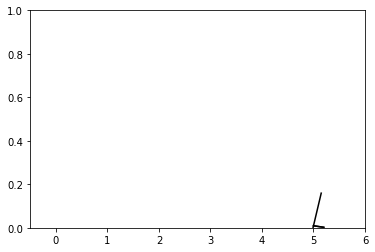

In [25]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
#ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.5,6])
    ax.set_ylim([0,1])
    
    #plot body
    body_xb = m.q0[i,'x'].value - 0.5*m.lb
    body_yb = m.q0[i,'z'].value - 0.5*m.lb
    body_xf = m.q0[i,'x'].value + 0.5*m.lb
    body_yf = m.q0[i,'z'].value + 0.5*m.lb
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
    
    #plot leg 
    legL_xt = m.q0[i,'x'].value 
    legL_yt = m.q0[i,'z'].value 
    legL_xb = m.q0[i,'x'].value + m.q0[i,'rL'].value*cos(m.q0[i,'theta_Ll'].value)
    legL_yb = m.q0[i,'z'].value - m.q0[i,'rL'].value*sin(m.q0[i,'theta_Ll'].value)
    ax.plot([legL_xt,legL_xb],[legL_yt,legL_yb],color='xkcd:black')
    
    #plot leg 
    legR_xt = m.q0[i,'x'].value 
    legR_yt = m.q0[i,'z'].value 
    legR_xb = m.q0[i,'x'].value + m.q0[i,'rR'].value*cos(m.q0[i,'theta_Rl'].value)
    legR_yb = m.q0[i,'z'].value - m.q0[i,'rR'].value*sin(m.q0[i,'theta_Rl'].value)
    ax.plot([legR_xt,legR_xb],[legR_yt,legR_yb],color='xkcd:black')
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=False)

HTML(animate.to_jshtml())